In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import win32com.client
import json
from scipy.signal import periodogram
from scipy.signal import butter, filtfilt
import statsmodels
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.filters.bk_filter import bkfilter

: 

In [2]:
''' Obtain data from Bloomberg store to try things out.
    Take 10 tickers that are in a related sector such that there are underlying factors.
'''

def retrieve_indices(tickers, ticker_names):
    df = None
    for k in range(len(tickers)):
        url = 'http://rdpeds01.ortec.finance/bloomberg/json/' + tickers[k] + '/PX_LAST/monthly'
        h = win32com.client.Dispatch('WinHTTP.WinHTTPRequest.5.1')
        h.SetAutoLogonPolicy(0)
        h.Open('GET', url, False)
        h.Send()
        try:
            js = json.loads(h.responseText)
        except ValueError:
            raise ValueError("The datastore did not repond with JSON: %s", url)
        if js['status'] != 0:
            raise ValueError("Data store returned status %s for url %s", js['response'], url)
        
        res = pd.Series(js['response'],name=ticker_names[k])
        if df is None:
            df = pd.DataFrame(index = res.index)
            
        df = df.join(res.to_frame(),how='outer')
    return df


ticker_list_indices = ['AEX%20Index','BE500%20Index','DAX%20Index','E100%20Index','SPX%20Index','KAX%20Index','ISEQ%20Index','FTSEMIB%20Index','MADX%20Index']
name_list_indices = ['AEX', 'BE', 'GER', 'EUR', 'US', 'DEN','IRE','ITA','ES']
df_indices = retrieve_indices(ticker_list_indices, name_list_indices)


# Obtain data of specific countries/tickers

def df_returns_ticker(df, ticker, frequency=30):
    #df_out =  df[[ticker]].dropna()
    df_out[ticker] = df_out[ticker].pct_change(periods=frequency)
    return df_out

# Simpler: obtain monhtly returns of all tickers simulatenously
#df_month_returns = df_indices[name_list_indices].pct_change(periods=30)


In [3]:
'''
    Initial class written by GPT-4 based on prompt:
    
    Create a Python class that takes my data as input (monthly frequency, economic 
    variable, stored in a Pandas DataFrame), and only computes the spectral density 
    using a pre-existing package.
    
'''

class SpectralDensity:
    def __init__(self, data: pd.DataFrame, column_name: str):
        """
        data: A pandas DataFrame where rows represent ordered time points (monthly).
        column_name: The column in the DataFrame you wish to analyze.
        """
        self.data = data[column_name].dropna().values  # removing any NaN values
        self.frequencies = None
        self.density = None

    def compute_spectral_density(self):
        """
        Compute the spectral density using the periodogram function.
        """
        self.frequencies, self.density = periodogram(self.data, fs=12)  # fs=12 for monthly data
        return self.frequencies, self.density


    
AEX_analyzer = SpectralDensity(df_indices, 'AEX')
AEX_frequencies, AEX_density = AEX_analyzer.compute_spectral_density()

US_analyzer = SpectralDensity(df_indices, 'US')
US_frequencies, US_density = US_analyzer.compute_spectral_density()

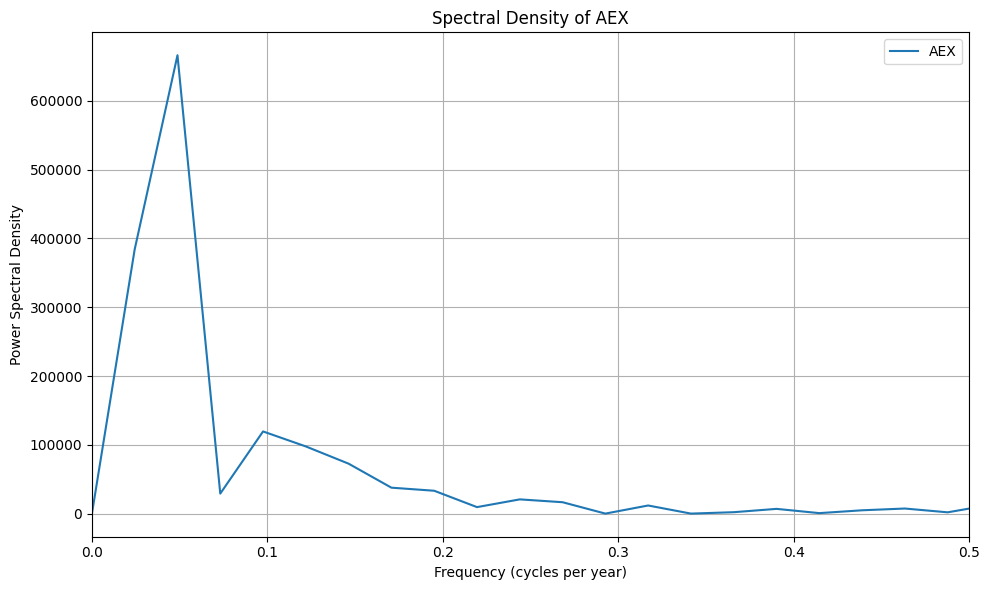

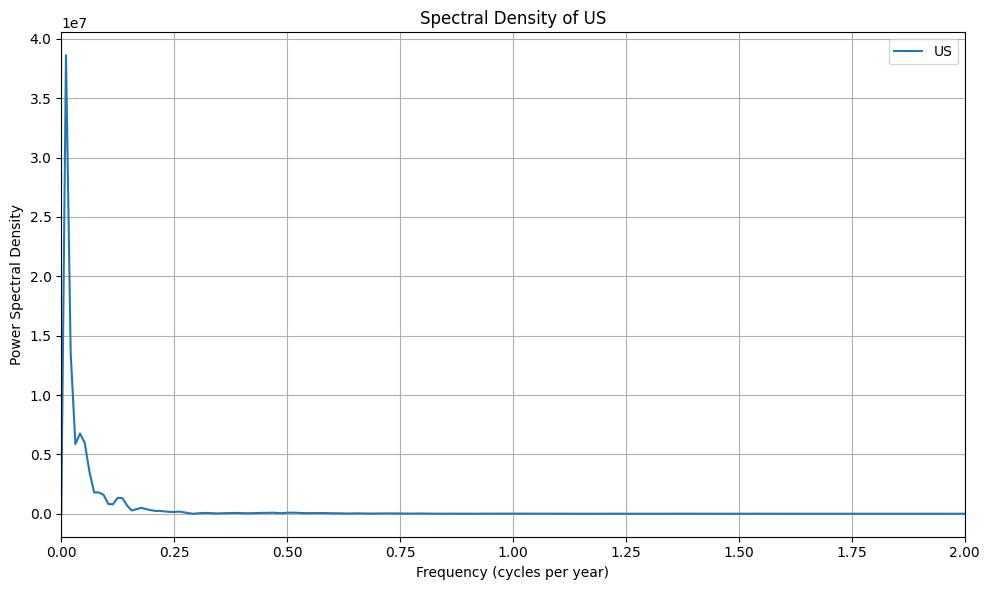

Implied Variance from Spectral Density: 39184.125249676115
Sample Variance: 39184.125249676115
Implied Variance from Spectral Density: 952112.9064139606
Sample Variance: 952112.9064139606


In [4]:
'''
    Second & third version class written by GPT-4 based on prompt:
    
    
    Great. Now add a method that allows us to plot this, with nice 
    formatting (label axes, legend, title)
    
    ---
    
    Now add a method that compares the implied variance from the spectral 
    density with the sample variance of the data. If I understand correctly, 
    these should be the same for zero-mean data (which I have in this case).
    
    
    
'''

class SpectralDensity:
    def __init__(self, data: pd.DataFrame, column_name: str):
        """
        data: A pandas DataFrame where rows represent ordered time points (monthly).
        column_name: The column in the DataFrame you wish to analyze.
        """
        self.data = data[column_name].dropna().values  # removing any NaN values
        self.frequencies = None
        self.density = None
        self.column_name = column_name

    def compute_spectral_density(self):
        """
        Compute the spectral density using the periodogram function.
        """
        self.frequencies, self.density = periodogram(self.data, fs=12)  # fs=12 for monthly data
        return self.frequencies, self.density
    
    def plot_spectral_density(self, xlim = None):
        """
        Plot the spectral density with appropriate labels, legend, and title.
        """
        if self.frequencies is None or self.density is None:
            self.compute_spectral_density()
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.frequencies, self.density, label=self.column_name)
        plt.title(f'Spectral Density of {self.column_name}')
        plt.xlabel('Frequency (cycles per year)')
        plt.ylabel('Power Spectral Density')
        if xlim:
            plt.xlim(xlim)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def variance_comparison(self):
        """
        Compare the implied variance from the spectral density with the sample variance of the data.
        Returns the implied variance and sample variance.
        """
        # Check if the spectral density has been computed. If not, compute it.
        if self.frequencies is None or self.density is None:
            self.compute_spectral_density()
        
        # Implied variance from spectral density. 
        # Frequency resolution
        delta_f = self.frequencies[1] - self.frequencies[0]
        
        # The factor of 2 accounts for the negative frequencies not explicitly computed in the periodogram.
        implied_variance = np.sum(self.density)*delta_f
        
        # Sample variance of the data
        sample_variance = np.var(self.data)
        
        return implied_variance, sample_variance
        

# Create spectral density plots
AEX_analyzer = SpectralDensity(df_indices, 'AEX')
AEX_frequencies, AEX_density = AEX_analyzer.compute_spectral_density()
AEX_analyzer.plot_spectral_density(xlim=(0,.5))

US_analyzer = SpectralDensity(df_indices, 'US')
US_frequencies, US_density = US_analyzer.compute_spectral_density()
US_analyzer.plot_spectral_density(xlim=(0,2))


# Check if the implied variance from spectral density matches sample variance
AEX_imp_var, AEX_sample_var = AEX_analyzer.variance_comparison()
US_imp_var, US_sample_var = US_analyzer.variance_comparison()

print(f"Implied Variance from Spectral Density: {AEX_imp_var}")
print(f"Sample Variance: {AEX_sample_var}")

print(f"Implied Variance from Spectral Density: {US_imp_var}")
print(f"Sample Variance: {US_sample_var}")


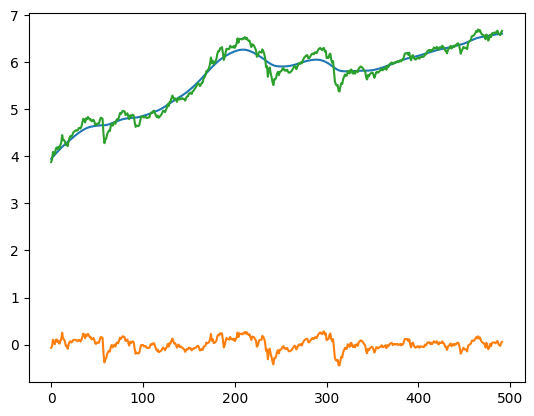

In [5]:
'''
    Next step is to actually do the frequency decomposition using the following prompt:
    
    Now I want to decompose the data into components, each with a distinct frequency 
    band. Let us start simple: write code such that the input data is decomposed into 
    two frequencies, one for low-frequencies and one for high-frequencies, where the 
    cut-off is specified by the user
    
'''



class FrequencyDecomposition:
    def __init__(self, data: pd.DataFrame, column_name: str):
        """
        data: A pandas DataFrame where rows represent ordered time points (monthly).
        column_name: The column in the DataFrame you wish to analyze.
        """
        self.data = data[column_name].dropna().values
        self.fs = 12  # Sampling frequency for monthly data
        self.low_freq_component = None
        self.high_freq_component = None
    
    def decompose(self, cutoff_frequency):
        """
        Decompose the data into low and high frequency components based on the cutoff_frequency.
        cutoff_frequency: Specified in cycles per year.
        """
        # Normalize the cutoff frequency for the butter function
        nyquist = 0.5 * self.fs
        normal_cutoff = cutoff_frequency / nyquist

        # Design a low-pass filter
        b, a = butter(1, normal_cutoff, btype='low', analog=False)

        # Apply the filter to get the low-frequency component
        self.low_freq_component = filtfilt(b, a, self.data)
        
        # Subtract the low-frequency component from the original data to get the high-frequency component
        self.high_freq_component = self.data - self.low_freq_component

        return self.low_freq_component, self.high_freq_component


df_indices_logs = np.log(df_indices)
AEX_decomposer = FrequencyDecomposition(df_indices_logs, 'AEX')
AEX_low_freq, AEX_high_freq = AEX_decomposer.decompose(cutoff_frequency=1/8)  
plt.plot(AEX_low_freq)
plt.plot(AEX_high_freq)
plt.plot(AEX_low_freq + AEX_high_freq)

                 US
1990/01/31   329.08
1990/02/28   331.89
1990/03/30   339.94
1990/04/30   330.80
1990/05/31   361.23
...             ...
2023/03/31  4109.31
2023/04/28  4169.48
2023/05/31  4179.83
2023/06/30  4450.38
2023/07/31  4588.96

[403 rows x 1 columns]
[ 329.08  331.89  339.94  330.8   361.23  358.02  356.15  322.56  306.05
  304.    322.22  330.22  343.93  367.07  375.22  375.35  389.83  371.16
  387.81  395.43  387.86  392.46  375.22  417.09  408.79  412.7   403.69
  414.95  415.35  408.14  424.21  414.03  417.8   418.68  431.35  435.71
  438.78  443.38  451.67  440.19  450.19  450.53  448.13  463.56  458.93
  467.83  461.79  466.45  481.61  467.14  445.77  450.91  456.5   444.27
  458.26  475.49  462.69  472.35  453.69  459.27  470.42  487.39  500.71
  514.71  533.4   544.75  562.06  561.88  584.41  581.5   605.37  615.93
  636.02  640.43  645.5   654.17  669.12  670.63  639.95  651.99  687.31
  705.27  757.02  740.74  786.16  790.82  757.12  801.34  848.28  885.14
  954.

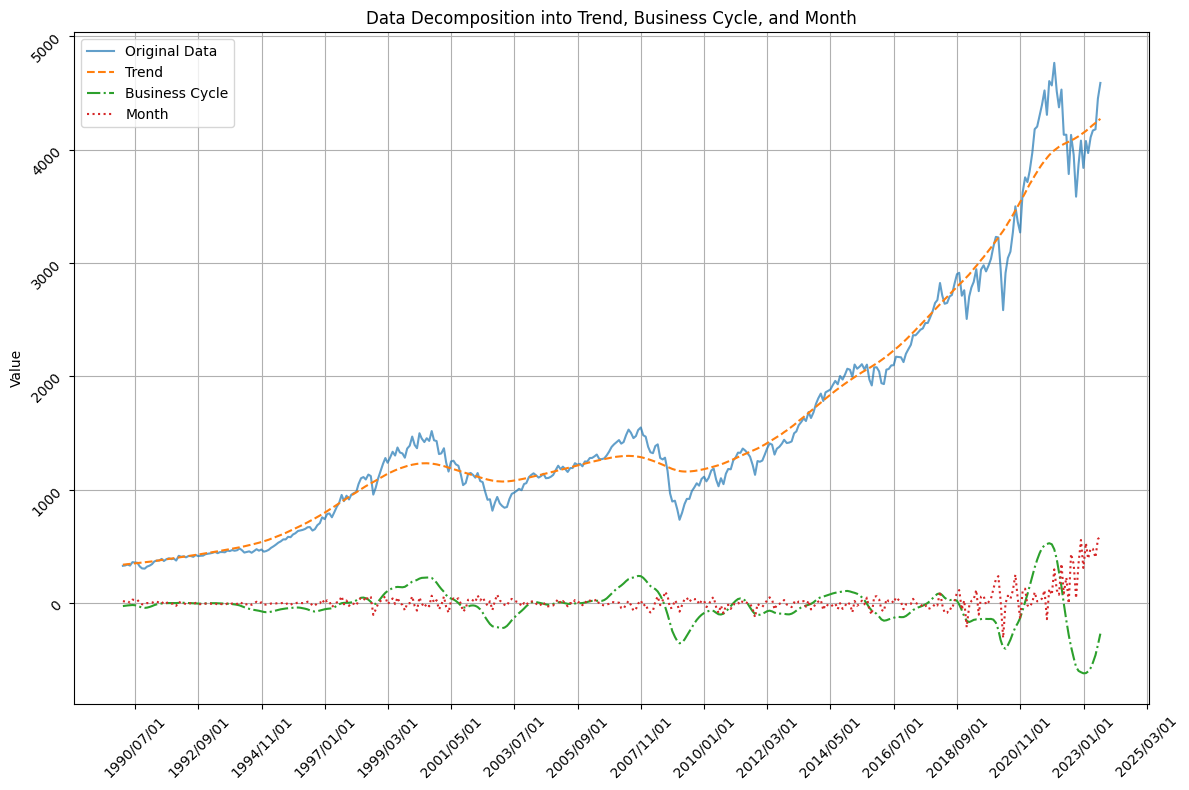

In [36]:
'''
    Second version of frequency decomposition using the following prompt:
    
    Now suppose I want to further decompose this into three 
    components which we label: trend, business cycle, and month. Please adjust 
    the code to have two cutoff frequencies. Also provide a method that plots 
    these three components, together with the original data (again with nice formatting).
    
'''


class FrequencyDecomposition:
    def __init__(self, data: pd.DataFrame, column_name: str):
        """
        data: A pandas DataFrame where rows represent ordered time points (monthly).
        column_name: The column in the DataFrame you wish to analyze.
        """
        self.index = data[column_name].dropna().index
        self.data = data[column_name].dropna().values
        print(self.data)
        self.fs = 12  # Sampling frequency for monthly data
        self.trend = None
        self.business_cycle = None
        self.month = None  
        
    def decompose(self, low_cutoff, high_cutoff):
        """
        Decompose the data into trend, business cycle, and month components.
        low_cutoff: Lower cutoff frequency in cycles per year.
        high_cutoff: Upper cutoff frequency in cycles per year.
        """
        # Normalize the cutoff frequencies for the butter function
        nyquist = 0.5 * self.fs
        normal_low_cutoff = low_cutoff / nyquist
        normal_high_cutoff = high_cutoff / nyquist
        
        # 1. Design and apply a low-pass filter to get the trend component
        b, a = butter(1, normal_low_cutoff, btype='low', analog=False)
        self.trend = filtfilt(b, a, self.data)
        
        # 2. Design and apply a bandpass filter to get the business cycle component
        b, a = butter(1, [normal_low_cutoff, normal_high_cutoff], btype='band', analog=False)
        self.business_cycle = filtfilt(b, a, self.data)
        
        # 3. Subtract trend and business cycle components to get the month component
        self.month = self.data - self.trend - self.business_cycle
        
        return self.trend, self.business_cycle, self.month
    
    def apply_hp_filter(self, lamb=129600):
        """
        Apply the Hodrick-Prescott filter to decompose the data into trend and cycle components.

        lamb: The smoothness parameter. Commonly used values are 129600 for monthly data,
              1600 for quarterly data, and 6.25 for annual data.
        """
        self.hp_cycle, self.hp_trend =  statsmodels.tsa.filters.hp_filter.hpfilter(self.data, lamb=lamb)
        
    def apply_bk_filter(self, low, high, K):
        """
        Apply the Baxter-King filter to extract cyclical components from the time series.

        low: The lower period for the band-pass filter (e.g., 6 for 6 months).
        high: The higher period for the band-pass filter (e.g., 32 for 32 months).
        K: Lead-lag length for the filter. Baxter and King recommend setting it 
           to 12 for monthly data and 3 for quarterly data.12
        """
        self.bk_cycle = statsmodels.tsa.filters.bk_filter.bkfilter(self.data, low=low, high=high, K=K)

        
    def plot_components(self, hp_filter=False, bk_filter=False):
        """
        Plot the original data and its components.
        """
        plt.figure(figsize=(12, 8))
        x = [dt.datetime.strptime(d,'%Y/%m/%d').date() for d in self.index]
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=int(len(x)/15)))
        plt.tick_params(labelrotation=45)
        
        if hp_filter:
            # Check if HP filter results exist
            if self.hp_trend is None or self.hp_cycle is None:
                raise ValueError("HP filter results not available. Apply the HP filter first.")
            plt.plot(x,self.data, label="Original Data", alpha=.7)
            plt.plot(x,self.hp_trend, label="HP Trend", linestyle='--')
            plt.plot(x,self.hp_cycle, label="HP Cycle", linestyle='-.')
        elif bk_filter:
            # Check if BK filter results exist
            if self.bk_cycle is None:
                raise ValueError("BK filter results not available. Apply the BK filter first.")
            plt.plot(x,self.data, label="Original Data", alpha=.7)
            plt.plot(x,self.hp_cycle, label="HP Cycle", linestyle='-.')
        else:
            # Check if FFT decomposition results exist
            if self.trend is None or self.business_cycle is None or self.month is None:
                raise ValueError("FFT decomposition results not available. Decompose the data first.")
            plt.plot(x,self.data, label='Original Data', alpha=.7)
            plt.plot(x,self.trend, label='Trend', linestyle='--')
            plt.plot(x,self.business_cycle, label='Business Cycle', linestyle='-.')
            plt.plot(x,self.month, label='Month', linestyle=':')
        

        plt.title('Data Decomposition into Trend, Business Cycle, and Month')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



#AEX_decomposer = FrequencyDecomposition(df_indices, 'AEX')
#AEX_trend, AEX_business_cycle, AEX_month = AEX_decomposer.decompose(low_cutoff=1/16, high_cutoff=1/2)
#AEX_decomposer.plot_components()


US_data_part = pd.DataFrame(df_indices['US']['1990/01/31':'2023/07/31'])
print(US_data_part)
US_decomposer = FrequencyDecomposition(US_data_part, 'US')
US_trend, US_business_cycle, US_month = US_decomposer.decompose(low_cutoff=1/8, high_cutoff=1)
#US_decomposer.apply_hp_filter()
#US_decomposer.apply_bk_filter(low=1/8, high=1, K=12)
#US_bk_BC = US_decomposer.apply_bk_filter(low=6, high=36, K=12)
US_decomposer.plot_components()


C:\Users\raviark\AppData\Local\Temp\ipykernel_22256\2004900117.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  plt.plot(df_indices['AEX'].pct_change())


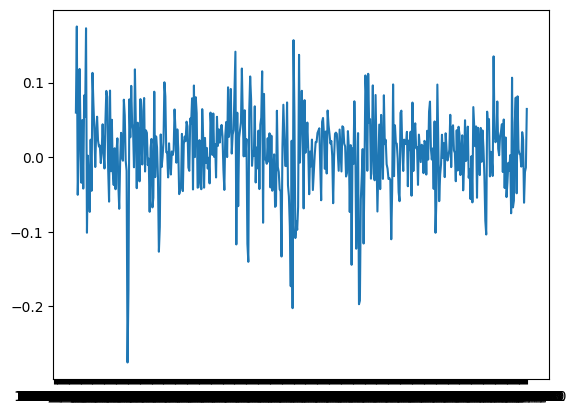

In [6]:
plt.plot(df_indices['AEX'].pct_change())